<a href="https://colab.research.google.com/github/blotzartdd/blotzartdd.github.io/blob/main/Seminar_image_classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация изображений

Привет!

Мы будем решать задачу классификации картинок на 10 классов. 

Мы будем работать с датасетом СIFAR10 и библиотекой PyTorch, которая создана специально для работы с нейронными сетями.

![alt text](https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png)

## 1. Загрузка датасета


In [ ]:
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

# модули библиотеки PyTorch
import torch
from torchvision import datasets, transforms
# метрика качества 
from sklearn.metrics import accuracy_score

In [ ]:
train_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=transforms.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
train_data

In [ ]:
train_size = int(len(train_data) * 0.8)
val_size = len(train_data) - train_size

train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

In [ ]:
train_size, val_size

(40000, 10000)

In [ ]:
test_data = datasets.CIFAR10(root="./data", train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
dataiter = iter(train_loader)
# батч картинок и батч ответов к картинкам
images, labels = dataiter.next()

In [ ]:
images.shape, labels.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [ ]:
labels

tensor([3, 5, 1, 6, 3, 6, 2, 3, 5, 1, 0, 2, 1, 7, 9, 9, 2, 9, 3, 7, 1, 0, 3, 2,
        8, 6, 0, 3, 9, 8, 4, 8, 3, 6, 2, 3, 5, 6, 2, 5, 0, 0, 8, 8, 4, 6, 9, 6,
        0, 4, 3, 2, 5, 6, 0, 6, 5, 3, 1, 4, 5, 6, 9, 6])

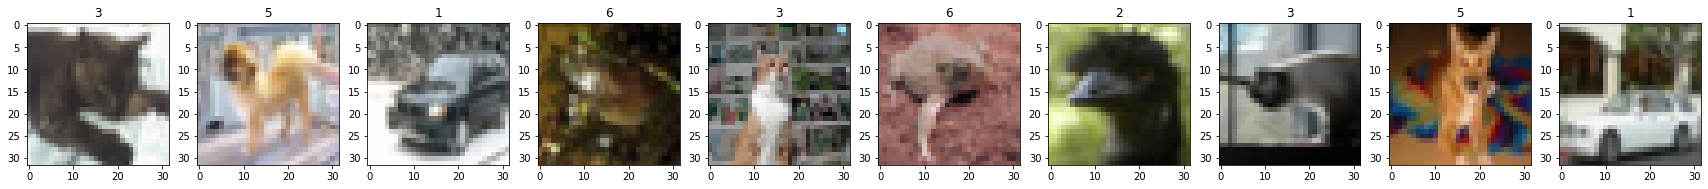

In [ ]:
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
        axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
        axes[i].set_title(labels[i].numpy())
    plt.show()

show_imgs(images, labels)


Таблица соответствий номеров ответов и классов:

| Label        | Class           |
| ------------- |:-------------:|
| 0     | Самолет |
| 1    | Автомобиль      | 
| 2 | Птица      |
| 3 | Кошка      |
| 4 | Олень      |
| 5 | Собака      |
| 6 | Лягушка     |
| 7 | Лошадь     |
| 8 | Корабль     |
| 9 | Грузовик     |


Создадим словарь соответствий номера и названия, чтобы проще интерпретировать выход нейронной сети:

In [ ]:
num_to_name = {
    0: "Самолет",
    1: "Автомобиль",
    2: "Птица",
    3: "Кошка",
    4: "Олень",
    5: "Собака",
    6: "Лягушка",
    7: "Лошадь",
    8: "Корабль",
    9: "Грузовик"
}

Импортируем нужные модули для обучения сети:

In [ ]:
# модуль, где определены слои для нейронных сетей
import torch.nn as nn
# модуль, где определены активации для слоев нейронных сетей
import torch.nn.functional as F

## 2. Обучение и тест базовой сети.

Для начала построим двуслойную полносвязную нейронную сеть, обучим ее и посчитаем метрику accuracy на тестовой выборке:

<a href="https://ibb.co/prDn4RG"><img src="https://i.ibb.co/G3wFCtB/Screen-Shot-2020-03-14-at-9-43-10-PM.png" alt="Screen-Shot-2020-03-14-at-9-43-10-PM" border="0"></a>

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = torch.nn.Flatten()
        self.fc1 = nn.Linear(32*32*3, 256) #fully-connected полносвязный
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        # forward pass сети

        # переводим входной объект из картинки в вектор
        x = self.flatten(x)
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = F.relu(self.fc1(x))
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = self.fc2(x)
        return x

Давайте вынесем код обучения сети в отдельную функцию, чтобы каждый раз при изменении сети не копировать его. Код обучения мы менять не будем.

In [ ]:
def train(model, optimizer, loss_fn, n_epoch=6):

    train_losses = []
    val_accuracies = []
    val_losses = []
    
    # обучаем сеть
    for epoch in tqdm_notebook(range(n_epoch)):
        train_dataiter = iter(train_loader)
        running_loss = 0.0

        model.train(True)
        for i, batch in enumerate(tqdm_notebook(train_dataiter)):
            X_batch, y_batch = batch # так получаем текущий батч
            
            logits = model(X_batch) # forward pass (получение ответов на батч картинок)
            loss = loss_fn(logits, y_batch) # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss.backward() # backpropagation (вычисление градиентов)
            optimizer.step() # обновление весов сети
            optimizer.zero_grad() # обнуляем веса
            # выведем текущий loss
            running_loss += loss.item()

            # выведем лосс каждые 50 батчей
            if i % 50 == 49:
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 50))
                train_losses.append(running_loss / 50)
                running_loss = 0.0

        # evaluate on val
        model.train(False)
        val_dataiter = iter(val_loader)


        val_loss_per_epoch = 0
        val_accuracy_per_epoch = 0
        for i, batch in enumerate(tqdm_notebook(val_dataiter)):
            # так получаем текущий батч
            X_batch, y_batch = batch
            with torch.no_grad():
                logits = model(X_batch)
                y_pred = torch.argmax(logits, dim=1)
                val_accuracy_per_epoch += np.mean(y_pred.numpy() == y_batch.numpy())

                val_loss_per_epoch += loss_fn(logits, y_batch)

        val_accuracies.append(val_accuracy_per_epoch / (i + 1))
        val_losses.append(val_loss_per_epoch / (i + 1))

    print('Обучение закончено')
    return model, train_losses, val_losses, val_accuracies

In [ ]:
# объявляем сеть
net = SimpleNet()

In [ ]:
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-3 #0.001
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [ ]:
# теперь обучить сеть можно вызвав функцию train и передав туда переменную сети.
net, train_losses, val_losses, val_accuracies = train(net, optimizer, loss_fn, n_epoch=15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/625 [00:00<?, ?it/s]

[1,    50] loss: 2.233
[1,   100] loss: 2.037
[1,   150] loss: 2.001
[1,   200] loss: 1.949
[1,   250] loss: 1.919
[1,   300] loss: 1.869
[1,   350] loss: 1.873
[1,   400] loss: 1.816
[1,   450] loss: 1.848
[1,   500] loss: 1.791
[1,   550] loss: 1.790
[1,   600] loss: 1.776


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

[2,    50] loss: 1.773
[2,   100] loss: 1.766
[2,   150] loss: 1.762
[2,   200] loss: 1.727
[2,   250] loss: 1.765
[2,   300] loss: 1.738
[2,   350] loss: 1.732
[2,   400] loss: 1.715
[2,   450] loss: 1.699
[2,   500] loss: 1.697
[2,   550] loss: 1.677
[2,   600] loss: 1.735


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

[3,    50] loss: 1.661
[3,   100] loss: 1.638
[3,   150] loss: 1.670
[3,   200] loss: 1.724
[3,   250] loss: 1.646
[3,   300] loss: 1.677
[3,   350] loss: 1.647
[3,   400] loss: 1.682
[3,   450] loss: 1.674
[3,   500] loss: 1.664
[3,   550] loss: 1.651
[3,   600] loss: 1.681


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

[4,    50] loss: 1.638
[4,   100] loss: 1.611
[4,   150] loss: 1.648
[4,   200] loss: 1.631
[4,   250] loss: 1.627
[4,   300] loss: 1.613
[4,   350] loss: 1.623
[4,   400] loss: 1.629
[4,   450] loss: 1.594
[4,   500] loss: 1.648
[4,   550] loss: 1.637
[4,   600] loss: 1.598


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

[5,    50] loss: 1.604
[5,   100] loss: 1.613
[5,   150] loss: 1.622
[5,   200] loss: 1.591
[5,   250] loss: 1.603
[5,   300] loss: 1.617
[5,   350] loss: 1.588
[5,   400] loss: 1.567
[5,   450] loss: 1.579
[5,   500] loss: 1.547
[5,   550] loss: 1.621
[5,   600] loss: 1.578


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

[6,    50] loss: 1.562
[6,   100] loss: 1.577
[6,   150] loss: 1.563
[6,   200] loss: 1.555
[6,   250] loss: 1.561
[6,   300] loss: 1.545
[6,   350] loss: 1.550
[6,   400] loss: 1.566
[6,   450] loss: 1.553
[6,   500] loss: 1.550
[6,   550] loss: 1.577
[6,   600] loss: 1.533


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

[7,    50] loss: 1.531
[7,   100] loss: 1.556
[7,   150] loss: 1.547
[7,   200] loss: 1.537
[7,   250] loss: 1.552
[7,   300] loss: 1.539
[7,   350] loss: 1.494
[7,   400] loss: 1.574
[7,   450] loss: 1.546
[7,   500] loss: 1.532
[7,   550] loss: 1.549
[7,   600] loss: 1.529


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

[8,    50] loss: 1.541
[8,   100] loss: 1.515
[8,   150] loss: 1.530
[8,   200] loss: 1.531
[8,   250] loss: 1.520
[8,   300] loss: 1.492
[8,   350] loss: 1.503
[8,   400] loss: 1.513
[8,   450] loss: 1.506
[8,   500] loss: 1.523
[8,   550] loss: 1.539
[8,   600] loss: 1.513


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

[9,    50] loss: 1.486
[9,   100] loss: 1.506
[9,   150] loss: 1.524
[9,   200] loss: 1.472
[9,   250] loss: 1.524
[9,   300] loss: 1.514
[9,   350] loss: 1.484
[9,   400] loss: 1.499
[9,   450] loss: 1.531
[9,   500] loss: 1.483
[9,   550] loss: 1.508
[9,   600] loss: 1.523


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

[10,    50] loss: 1.478
[10,   100] loss: 1.480
[10,   150] loss: 1.509
[10,   200] loss: 1.470
[10,   250] loss: 1.514
[10,   300] loss: 1.457
[10,   350] loss: 1.496
[10,   400] loss: 1.526
[10,   450] loss: 1.475
[10,   500] loss: 1.446
[10,   550] loss: 1.508
[10,   600] loss: 1.501


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

[11,    50] loss: 1.452
[11,   100] loss: 1.486
[11,   150] loss: 1.481
[11,   200] loss: 1.476
[11,   250] loss: 1.491
[11,   300] loss: 1.488
[11,   350] loss: 1.446
[11,   400] loss: 1.477
[11,   450] loss: 1.477
[11,   500] loss: 1.463
[11,   550] loss: 1.471
[11,   600] loss: 1.502


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

[12,    50] loss: 1.402
[12,   100] loss: 1.483
[12,   150] loss: 1.464
[12,   200] loss: 1.448
[12,   250] loss: 1.467
[12,   300] loss: 1.473
[12,   350] loss: 1.461
[12,   400] loss: 1.455
[12,   450] loss: 1.443
[12,   500] loss: 1.480
[12,   550] loss: 1.487
[12,   600] loss: 1.471


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

[13,    50] loss: 1.408
[13,   100] loss: 1.417
[13,   150] loss: 1.494
[13,   200] loss: 1.451
[13,   250] loss: 1.449
[13,   300] loss: 1.457
[13,   350] loss: 1.457
[13,   400] loss: 1.475
[13,   450] loss: 1.475
[13,   500] loss: 1.456
[13,   550] loss: 1.485
[13,   600] loss: 1.486


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

[14,    50] loss: 1.426
[14,   100] loss: 1.418
[14,   150] loss: 1.434
[14,   200] loss: 1.462
[14,   250] loss: 1.436
[14,   300] loss: 1.457
[14,   350] loss: 1.431
[14,   400] loss: 1.450
[14,   450] loss: 1.469
[14,   500] loss: 1.454
[14,   550] loss: 1.471
[14,   600] loss: 1.494


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

[15,    50] loss: 1.437
[15,   100] loss: 1.436
[15,   150] loss: 1.461
[15,   200] loss: 1.424
[15,   250] loss: 1.480
[15,   300] loss: 1.422
[15,   350] loss: 1.394
[15,   400] loss: 1.434
[15,   450] loss: 1.406
[15,   500] loss: 1.465
[15,   550] loss: 1.452
[15,   600] loss: 1.452


  0%|          | 0/157 [00:00<?, ?it/s]

Обучение закончено


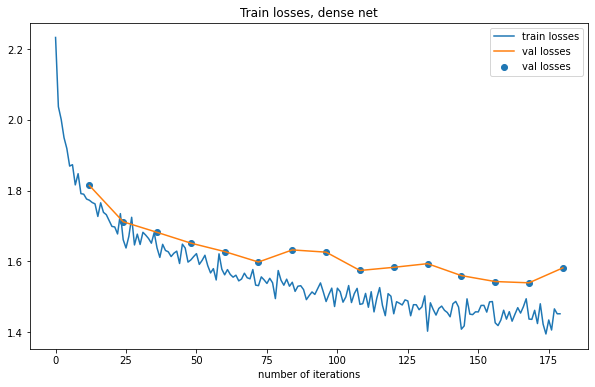

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Train losses, dense net')
plt.plot(np.arange(len(train_losses)), train_losses, label='train losses')
plt.plot(np.arange(1, len(val_losses) + 1) * (len(train_losses) // len(val_losses)), 
         val_losses, label='val losses')
plt.scatter(np.arange(1, len(val_losses) + 1) * (len(train_losses) // len(val_losses)), 
         val_losses, label='val losses')
plt.xlabel('number of iterations')
plt.legend()
plt.show()

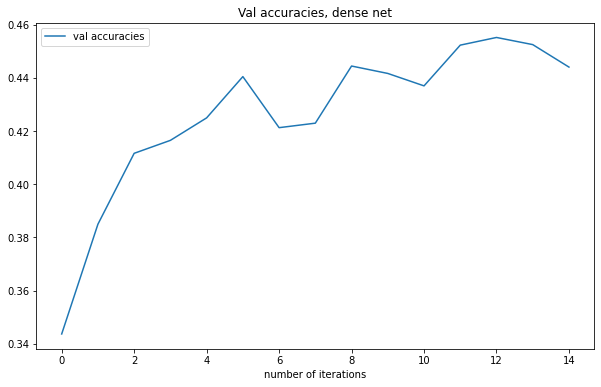

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Val accuracies, dense net')
plt.plot(np.arange(len(val_accuracies)), val_accuracies, label='val accuracies')
plt.xlabel('number of iterations')
plt.legend()
plt.show()

Посчитаем accuracy на test:

In [ ]:
def evaluate(model, dataloader, name='test'):
    accuracy = 0.

    dataiter = iter(dataloader)
    for i, batch in enumerate(tqdm_notebook(dataiter)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        with torch.no_grad():
            logits = model(X_batch)
            y_pred = torch.argmax(logits, dim=1)
            accuracy += np.mean(y_pred.numpy() == y_batch.numpy())
    print(f'{name} accuracy is {accuracy / (i + 1)}')
    return accuracy / (i + 1)

In [ ]:
test_dataiter = iter(test_loader)
evaluate(net, test_dataiter, 'test');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/157 [00:00<?, ?it/s]

test accuracy is 0.4524283439490446


In [ ]:
train_dataiter = iter(train_loader)
evaluate(net, train_dataiter, 'train');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/625 [00:00<?, ?it/s]

train accuracy is 0.4852


## 3. Обучение сверточной сети

Наша полносвязная двухслойная сеть не очень хорошо справляется с поставленной задачей. Давайте попробуем объявить и обучить сверточную нейронную сеть.

Наша нейронная сеть будет сожержать три слоя: два сверточных и один полносвязный. 
В качестве функции активации для внутренних слоев будем использовать [relu](https://neurohive.io/ru/osnovy-data-science/activation-functions/), для последнего слоя -- [softmax](https://neurohive.io/ru/osnovy-data-science/activation-functions/)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # conv
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(3,3)) #30x30
        # pool
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2)) #15x15
        # conv
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=9, kernel_size=(4,4)) #12x12
        # conv
        self.conv3 = nn.Conv2d(in_channels=9, out_channels=6, kernel_size=(3,3)) #10x10
        
        # flatten
        self.flatten = nn.Flatten()

        # linear
        self.fc1 = nn.Linear(10 * 10 * 6, 128)
        # linear
        self.fc2 = nn.Linear(128, 10)

    
    def forward(self, x):
        # forward pass сети
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = self.flatten(x)
        x = F.relu(self.fc1(x))

        x  = self.fc2(x)
        
        return x

In [ ]:
# объявляем сеть
conv_net = ConvNet()

In [ ]:
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-3
optimizer = torch.optim.Adam(conv_net.parameters(), lr=learning_rate)

In [ ]:
conv_net, train_losses_conv, val_losses_conv, val_accuracies_conv = train(conv_net, optimizer, loss_fn, n_epoch=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/625 [00:00<?, ?it/s]

[1,    50] loss: 2.288
[1,   100] loss: 2.068
[1,   150] loss: 1.969
[1,   200] loss: 1.872
[1,   250] loss: 1.819
[1,   300] loss: 1.801
[1,   350] loss: 1.761
[1,   400] loss: 1.724
[1,   450] loss: 1.681
[1,   500] loss: 1.697
[1,   550] loss: 1.654
[1,   600] loss: 1.673


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

[2,    50] loss: 1.633
[2,   100] loss: 1.653
[2,   150] loss: 1.626
[2,   200] loss: 1.605
[2,   250] loss: 1.585
[2,   300] loss: 1.567
[2,   350] loss: 1.553
[2,   400] loss: 1.532
[2,   450] loss: 1.522
[2,   500] loss: 1.552
[2,   550] loss: 1.539
[2,   600] loss: 1.540


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

[3,    50] loss: 1.506
[3,   100] loss: 1.468
[3,   150] loss: 1.494
[3,   200] loss: 1.481
[3,   250] loss: 1.455
[3,   300] loss: 1.459
[3,   350] loss: 1.447
[3,   400] loss: 1.443
[3,   450] loss: 1.472
[3,   500] loss: 1.434
[3,   550] loss: 1.446
[3,   600] loss: 1.400


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

[4,    50] loss: 1.424
[4,   100] loss: 1.427
[4,   150] loss: 1.389
[4,   200] loss: 1.394
[4,   250] loss: 1.408
[4,   300] loss: 1.393
[4,   350] loss: 1.389
[4,   400] loss: 1.365
[4,   450] loss: 1.357
[4,   500] loss: 1.405
[4,   550] loss: 1.401
[4,   600] loss: 1.404


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

[5,    50] loss: 1.354
[5,   100] loss: 1.377
[5,   150] loss: 1.343
[5,   200] loss: 1.359
[5,   250] loss: 1.336
[5,   300] loss: 1.359
[5,   350] loss: 1.352
[5,   400] loss: 1.370
[5,   450] loss: 1.305
[5,   500] loss: 1.356
[5,   550] loss: 1.294
[5,   600] loss: 1.333


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

[6,    50] loss: 1.320
[6,   100] loss: 1.293
[6,   150] loss: 1.316
[6,   200] loss: 1.346
[6,   250] loss: 1.290
[6,   300] loss: 1.316
[6,   350] loss: 1.277
[6,   400] loss: 1.313
[6,   450] loss: 1.292
[6,   500] loss: 1.304
[6,   550] loss: 1.318
[6,   600] loss: 1.284


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

[7,    50] loss: 1.268
[7,   100] loss: 1.265
[7,   150] loss: 1.274
[7,   200] loss: 1.291
[7,   250] loss: 1.272
[7,   300] loss: 1.303
[7,   350] loss: 1.302
[7,   400] loss: 1.278
[7,   450] loss: 1.279
[7,   500] loss: 1.271
[7,   550] loss: 1.280
[7,   600] loss: 1.242


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

[8,    50] loss: 1.280
[8,   100] loss: 1.249
[8,   150] loss: 1.279
[8,   200] loss: 1.244
[8,   250] loss: 1.266
[8,   300] loss: 1.272
[8,   350] loss: 1.262
[8,   400] loss: 1.238
[8,   450] loss: 1.251
[8,   500] loss: 1.258
[8,   550] loss: 1.277
[8,   600] loss: 1.258


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

[9,    50] loss: 1.251
[9,   100] loss: 1.271
[9,   150] loss: 1.241
[9,   200] loss: 1.266
[9,   250] loss: 1.214
[9,   300] loss: 1.217
[9,   350] loss: 1.259
[9,   400] loss: 1.245
[9,   450] loss: 1.234
[9,   500] loss: 1.251
[9,   550] loss: 1.236
[9,   600] loss: 1.229


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

[10,    50] loss: 1.223
[10,   100] loss: 1.218
[10,   150] loss: 1.222
[10,   200] loss: 1.239
[10,   250] loss: 1.211
[10,   300] loss: 1.201
[10,   350] loss: 1.218
[10,   400] loss: 1.210
[10,   450] loss: 1.186
[10,   500] loss: 1.263
[10,   550] loss: 1.213
[10,   600] loss: 1.214


  0%|          | 0/157 [00:00<?, ?it/s]

Обучение закончено


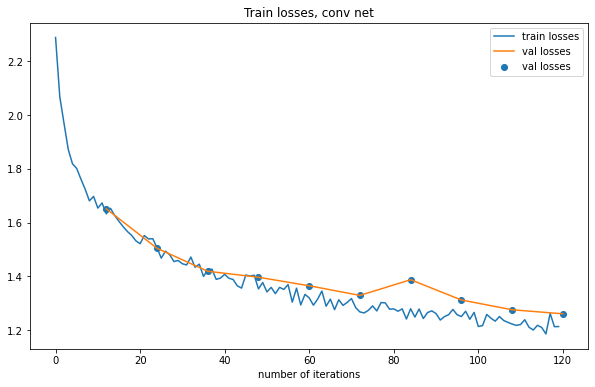

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Train losses, conv net')
plt.plot(np.arange(len(train_losses_conv)), train_losses_conv, label='train losses')
plt.plot(np.arange(1, len(val_losses_conv) + 1) * (len(train_losses_conv) // len(val_losses_conv)), 
         val_losses_conv, label='val losses')
plt.scatter(np.arange(1, len(val_losses_conv) + 1) * (len(train_losses_conv) // len(val_losses_conv)), 
         val_losses_conv, label='val losses')
plt.xlabel('number of iterations')
plt.legend()
plt.show()

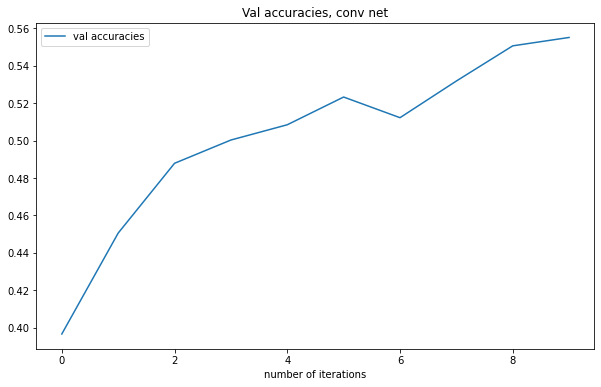

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Val accuracies, conv net')
plt.plot(np.arange(len(val_accuracies_conv)), val_accuracies_conv, label='val accuracies')
plt.xlabel('number of iterations')
plt.legend()
plt.show()

Посчитаем accuracy на test:

In [ ]:
test_dataiter = iter(test_loader)
evaluate(conv_net, test_dataiter, 'test');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/157 [00:00<?, ?it/s]

test accuracy is 0.5524482484076433


In [ ]:
train_dataiter = iter(train_loader)
evaluate(conv_net, train_dataiter, 'train');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/625 [00:00<?, ?it/s]

train accuracy is 0.577825


# Дополнительные материалы

## 4. BachNormalization

Одно из улучшений нейронной сети -- Батч Норм (BatchNorm). 

Смысл Батч Норма состоит в следующем: как вы знаете, когда мы обучаем нейронную сеть, мы обучаем ее батчами. Каждый батч картинок имеет разное распределение. Когда батч проходит через первый слой сети, выход первого слоя сети тоже имеет какое-то распределение. И для всех батчей оно немного разное. 

Таким образом, второй слой сети каждый раз принимает на вход данные, распределенные по-разному. И при обработке первого батча картинок веса сети подстраиваются под распределение картинок этого батча, а при обработке второго должны подстраиваться под другое распределение второго батча. Такое "метание" плохо сказывается на обучении сети, оно становится менее стабильным и в итоге сеть обучается хуже.

Батч норм -- это специальный слой сети, который используется после каждого слоя нейронной сети (кроме последнего). Он **нормализует** выходы слоев. Таким образом, следуюшему слою нейронной сети каждый раз передаются данные, распределенные примерно одинаково.

Чтобы лучше осознать полезность батч норма, можно вспомнить, что при изучении КНН мы говорили о том, что перед обучением модели признаки можно нормировать. Если есть два признака (например, возраст и доход), один из которых представлен десятками, а другой -- десятками тысяч, то для лучшего обучения модели их лучше привести к одному виду. Так и тут -- для лучшего обучения нейронной сети батчи лучше привести к одному виду.

Более подробно прочитать про батч норм можно тут: http://neerc.ifmo.ru/wiki/index.php?title=Batch-normalization

Напишем класс нейронной сети из трех слоев с батч нормализацией. За основу возьмем сеть, написанную выше: три слоя, 256, 64 и 10 нейронов в каждом.

**Задание**: реализуйте код нейронной сети с батч нормами. Допишите код в ячейке ниже в недостающих местах и запустите обучение сети.

In [ ]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = Flatten()
        self.fc1 = <первый линейный слой размерности <размер вектора картинки>*256>
        # задаем слой батч норма для выхода слоя сети с 256 нейронами
        self.bn1 = nn.BatchNorm1d(256) 
        self.fc2 = <первый линейный слой размерности 256*64>
        self.bn2 = <второй батч норм для выхода слоя сети с 64 нейронами>
        self.fc3 = <первый линейный слой размерности 64*10>
    
    def forward(self, x):
        # forward pass сети

        # переводим входной объект из картинки в вектор
        x = self.flatten(x)
        # применение слоев и батч нормов по очереди:
        <пропустите х через все слои и активации: fc1-relu-bn1-fc2-relu-bn2-fc3-softmax>

        return x

In [ ]:
# объявляем сеть
net = SimpleNN()

In [ ]:
# не изменяйте эту ячейку!
# эта ячейка проверяет ваш код на правильность
# если при запуске ячейка выдает ошибку, то у вас в коде ошибка

assert len(net.state_dict().keys()) == 16, "Неверное количество слоев. \
Проверьте, что в вашей сети три слоя и два батч-норма после первого и второго слоя."

fc1 = list(net.state_dict().keys())[0]
fc2 = list(net.state_dict().keys())[7]
fc3 = list(net.state_dict().keys())[14]

assert net.state_dict()[fc1].shape == (256, 3072), "Неверные размерности первого слоя. \
Должно быть размер вектора картинки * 256"
assert net.state_dict()[fc2].shape == (64, 256), "Неверные размерности второго слоя. \
Должно быть 256 * 64"
assert net.state_dict()[fc3].shape == (10, 64), "Неверные размерности третьего слоя. \
Должно быть 64 * 10"

Обучаем:

In [ ]:
net = train(net)

In [ ]:
test_dataiter = iter(test_loader)
images, labels = test_dataiter.next()

In [ ]:
accuracy_score(labels.numpy(), np.argmax(net.forward(images).detach().numpy(), axis=1))

Сделайте выводы =)